In [1]:
import os
os.chdir('../')
%pwd

'c:\\Users\\KUNAL MEHTA\\Desktop\\Data Science Training\\Projects\\Auto-Insurance-Risk-Profiling'

In [114]:
from langchain_core.tools import tool
from AutoInsurance.components.chat_feature import DocumentAnalysis, RiskProfileAnalysis, InsuranceRiskProfileAnalyzer
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [115]:
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

In [116]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [117]:
context = {'claim_likelihood': 0.07961550057185947,
 'claim_amount': 6434.927335660211,
 'normalized_claim_likelihood': 0.07556854055743428,
 'normalized_claim_amount': 0.19096796236790398,
 'risk_profile_probability': 'Medium',
 'risk_profile_cost': 'Low',
 'dynamic_combined_risk_score': 0.11417145522587874,
 'risk_group': 'High Risk'}

query = f"Give me 2 most similar rows based on the following context's risk group and demographic details {context}.Also give me the descriptive text on how the context customer relates with these customers"

In [118]:
# SQL database retriever
@tool("sql_tool")
def sql_tool(user_query: str):
    """
    This tool based on the customer context and user query fetch similar rows based on risk group and demographic details
      from SQL database and gives descriptive paragraph based on its profiles.
    """
    analysis = RiskProfileAnalysis(Path("artifacts/user_app/High Risk Profiles.csv"), Path("artifacts/user_app/Low Risk Profiles.csv"), Path("artifacts/user_app/Medium Risk Profiles.csv"))
    data = analysis.load_data()
    db = analysis.setup_database(data['df_high'], data['df_low'], data['df_medium'])
    agent_executor = analysis.setup_chat_agent(db)
    response = analysis.ask_question(agent_executor, user_query)

    return response

In [119]:
question = "what is the relation between age and risk group?"

In [120]:
llm = ChatOpenAI(model="gpt-3.5-turbo")

prompt_template = """
Answer the question in 2 lines from the provided context and make conclusions in a non technical manner, make sure to provide all the details, if the answer is not in
provided context just say, "answer is not available in the context", don't provide the wrong answer\n\n
Context:\n {context}?\n
Question: \n{question}\n

Answer:
"""

file_path = "artifacts/user_app/Demographic Analysis.pdf"

loader = PyPDFLoader(Path(file_path))
pages = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
splits = text_splitter.split_documents(pages)

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

[2024-09-20 20:54:38,381: INFO: segment: Collection langchain is not created.]
[2024-09-20 20:54:38,680: INFO: _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"]


In [121]:
# RAG 
@tool("rag_tool")
def rag_tool(question):
    """
    A tool used to answer questions related to demographics descriptive and hypothesis testing results.
    Basically regarding the statistical findings in a non techncial language
    """

    print('-> Calling RAG ->')
    # question = state
    print('Question:',question)
   
    template = prompt_template

    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [122]:
# Final answer tool
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
):
    """Returns a natural language response to the user in the form of a
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the profile of the potential customer
    based on the context and user input
    - `research_steps`: a few bullet points explaining the steps that were taken
    to create your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that tells about the similar profiles fetched from the SQL database and about the details
      from the output of RAG tool. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on the results.
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])

    return ""

In [123]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the profile report and the query:call the appropiate tools.
Once done you take the ouput from the RAG tool.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [124]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    sql_tool,
    rag_tool,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {   
        
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [125]:
inputs = {

    "input": f"Based on the following context: {context} and query: {query}, give me the concise paragraph. Also, use RAG tool Give me the relation between age and risk group from the hypothesis testing",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

[2024-09-20 20:54:41,203: INFO: _client: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"]


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AX84KaSTB2BOJLndrsaCjM9V', 'function': {'arguments': '{"user_query":"Give me 2 most similar rows based on the following context\'s risk group and demographic details {\'claim_likelihood\': 0.07961550057185947, \'claim_amount\': 6434.927335660211, \'normalized_claim_likelihood\': 0.07556854055743428, \'normalized_claim_amount\': 0.19096796236790398, \'risk_profile_probability\': \'Medium\', \'risk_profile_cost\': \'Low\', \'dynamic_combined_risk_score\': 0.11417145522587874, \'risk_group\': \'High Risk\'}"}', 'name': 'sql_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 128, 'prompt_tokens': 711, 'total_tokens': 839, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d44ea43a-bc61-4bfa-9a61-2017189ff0b4-0', tool_calls=[{'name': 'sql_tool', 'args': {'user_query': "Give 

In [126]:
out.tool_calls[0]["name"]

'sql_tool'

In [127]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

In [128]:
tool_str_to_func = {
    "sql_tool": sql_tool,
    "rag_tool": rag_tool,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [129]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("sql_tool", run_tool)
graph.add_node("rag_tool", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

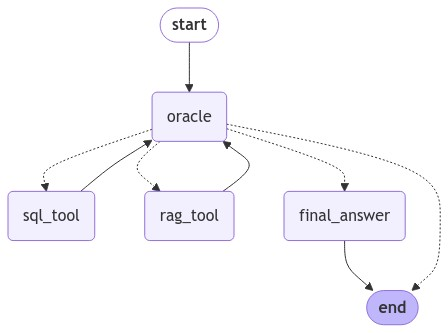

In [130]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [131]:
out = runnable.invoke({
    "input": f"Based on the following context: {context} and query: {query}, give me the concise paragraph. Also, use RAG tool Give me the relation between age and risk group from the hypothesis testing",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
[2024-09-20 20:54:45,090: INFO: _client: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"]
sql_tool.invoke(input={'user_query': "Give me 2 most similar rows based on the following context's risk group and demographic details {'claim_likelihood': 0.07961550057185947, 'claim_amount': 6434.927335660211, 'normalized_claim_likelihood': 0.07556854055743428, 'normalized_claim_amount': 0.19096796236790398, 'risk_profile_probability': 'Medium', 'risk_profile_cost': 'Low', 'dynamic_combined_risk_score': 0.11417145522587874, 'risk_group': 'High Risk'}"})


> Entering new SQL Agent Executor chain...
[2024-09-20 20:54:46,315: INFO: _client: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"]

Invoking: `sql_db_list_tables` with `{}`


high_risk, low_risk, medium_risk[2024-09-20 20:54:47,223: INFO: _client: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"]

Invoking: `sql_db_s

In [132]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

"""

In [133]:
out["intermediate_steps"]

[AgentAction(tool='sql_tool', tool_input={'user_query': "Give me 2 most similar rows based on the following context's risk group and demographic details {'claim_likelihood': 0.07961550057185947, 'claim_amount': 6434.927335660211, 'normalized_claim_likelihood': 0.07556854055743428, 'normalized_claim_amount': 0.19096796236790398, 'risk_profile_probability': 'Medium', 'risk_profile_cost': 'Low', 'dynamic_combined_risk_score': 0.11417145522587874, 'risk_group': 'High Risk'}"}, log='TBD'),
 AgentAction(tool='sql_tool', tool_input={'user_query': "Give me 2 most similar rows based on the following context's risk group and demographic details {'claim_likelihood': 0.07961550057185947, 'claim_amount': 6434.927335660211, 'normalized_claim_likelihood': 0.07556854055743428, 'normalized_claim_amount': 0.19096796236790398, 'risk_profile_probability': 'Medium', 'risk_profile_cost': 'Low', 'dynamic_combined_risk_score': 0.11417145522587874, 'risk_group': 'High Risk'}"}, log="Here are the 2 most similar

In [134]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Based on the context provided, two most similar rows were fetched from the database based on the risk group and demographic details. The risk group in focus is 'High Risk' with specific characteristics related to claim likelihood, claim amount, and risk profile. Additionally, the hypothesis testing results indicate a relationship between age and risk group.

RESEARCH STEPS
--------------
1. Fetched 2 most similar rows from the database based on the context's risk group and demographic details.
2. Conducted hypothesis testing to analyze the relationship between age and risk group.

REPORT
------
The two most similar rows retrieved from the database share similarities with the context customer in terms of risk profile probability, risk profile cost, and dynamic combined risk score. These customers have comparable demographic details and risk profiles, indicating a consistent pattern within the 'High Risk' group. The hypothesis testing results reveal a significa